In [113]:
import json
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import lightgbm as lgb
import sklearn.model_selection as model_selection
import contextily as cx
import geopandas as gpd

gpd.io.file.fiona.drvsupport.supported_drivers["KML"] = "rw"

In [114]:
# Utils

def rmlse(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

In [140]:
# import data 

# Read the apartment datasets
apartments_train = pd.read_csv("resources/data/apartments_train.csv").set_index("id")
apartments_train["split"] = "train"
apartments_test = pd.read_csv("resources/data/apartments_test.csv").set_index("id")
apartments_test["split"] = "test"

# Create a DataFrame of all apartments
apartments = pd.concat([apartments_train, apartments_test])

# Read the building datasets
buildings_train = pd.read_csv("resources/data/buildings_train.csv").set_index("id")
buildings_train["split"] = "train"
buildings_test = pd.read_csv("resources/data/buildings_test.csv").set_index("id")
buildings_test["split"] = "test"

# Create a GeoDataFrame of all buildings
buildings = pd.concat([buildings_train, buildings_test])
buildings = gpd.GeoDataFrame(buildings, geometry=gpd.points_from_xy(
    buildings.longitude, buildings.latitude, crs="EPSG:4326"
))

In [127]:
# Find all buildings missing coordinates
no_coords = buildings.latitude.isna() | buildings.longitude.isna()
street = buildings[~no_coords & (buildings.street == "пос. Коммунарка")]

buildings.loc[no_coords, "latitude"] = street.latitude.mean()
buildings.loc[no_coords, "longitude"] = street.longitude.mean()
buildings.loc[no_coords, "district"] = street.district.mode()[0]

In [141]:
# The coordinates of the southwest and northeast corners of a rectangle approximately encompassing Moscow
MOSCOW_SW_LAT = 55
MOSCOW_SW_LON = 35
MOSCOW_NE_LAT = 57
MOSCOW_NE_LON = 39

In [142]:
# Find all buildings with coordinates outside of Moscow
outside = (((buildings.latitude < MOSCOW_SW_LAT) | (buildings.latitude > MOSCOW_NE_LAT)
          | (buildings.longitude < MOSCOW_SW_LON) | (buildings.longitude > MOSCOW_NE_LON)))
buildings[outside][["split", "latitude", "longitude", "district", "street", "address", "constructed", "material", "stories"]]

for idx, building in buildings[outside].iterrows():
    street = buildings[~outside & (buildings.street == building.street)]
    if len(street):
        buildings.loc[idx, "latitude"] = street.latitude.mean()
        buildings.loc[idx, "longitude"] = street.longitude.mean()
        buildings.loc[idx, "district"] = street.district.mode()[0]
    else:
        buildings.loc[idx, "latitude"] = buildings[~outside].latitude.mean()
        buildings.loc[idx, "longitude"] = buildings[~outside].longitude.mean()

In [143]:
no_district = buildings.district.isna()
districts = buildings.loc[no_district].apply(
    lambda b: buildings.loc[
        (buildings[~no_district][["latitude", "longitude"]] - b[["latitude", "longitude"]]).abs().sum(axis=1).idxmin()
    ].district,
    axis=1
)
districts.rename("district", inplace=True)
buildings.update(districts)


In [144]:
stations = gpd.read_file("resources/metro_stations.kml", driver="KML").drop(columns=["Description"]).rename(columns={"Name": "name"})

# The Earth's radius in meters
EARTH_RADIUS = 6371000

# Create temporary columns for coordinates given in radians
stations["lon_rad"] = np.radians(stations.geometry.x)
stations["lat_rad"] = np.radians(stations.geometry.y)
buildings["lon_rad"] = np.radians(buildings.longitude)
buildings["lat_rad"] = np.radians(buildings.latitude)

# Calculate the distance to the nearest metro station for each building using
# the haversine formula with the Earth's radius as given above
buildings["metro_distance"] = buildings.apply(
    lambda row: np.min(
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((stations.lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(stations.lat_rad)
                * np.sin((stations.lon_rad - row.lon_rad) / 2) ** 2
            )
        )
    ),
    axis=1,
)


In [145]:
# Read park and garden location data
parks = gpd.read_file("resources/parks_and_gardens.kml", driver="KML").drop(columns=["Description"]).rename(columns={"Name": "name"})

# Create columns for coordinates given in radians
parks["lon_rad"] = np.radians(parks.geometry.x)
parks["lat_rad"] = np.radians(parks.geometry.y)

# Calculate the distance to the nearest park or garden for each building using
# the haversine formula with the Earth's radius as given above
buildings["park_distance"] = buildings.apply(
    lambda row: np.min(
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((parks.lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(parks.lat_rad)
                * np.sin((parks.lon_rad - row.lon_rad) / 2) ** 2
            )
        )
    ),
    axis=1,
)

# Drop the temporary radian columns
stations.drop(columns=["lon_rad", "lat_rad"], inplace=True)
buildings.drop(columns=["lon_rad", "lat_rad"], inplace=True)

In [147]:
buildings['district'] = buildings['district'].astype('category')

In [148]:
buildings_train = buildings.loc[buildings["split"] == "train", :]
buildings_train.drop(columns = "split", inplace = True)
apartments = pd.read_csv('resources/data/apartments_train.csv')
data = pd.merge(apartments, buildings_train, how='left', left_on='building_id', right_index=True)

buildings_test = buildings.loc[buildings["split"] == "test", :]
buildings_test.drop(columns = "split", inplace = True)
apartments_test = pd.read_csv('resources/data/apartments_test.csv')
data_test = pd.merge(apartments_test, buildings_test, how='left', left_on='building_id', right_index=True)

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


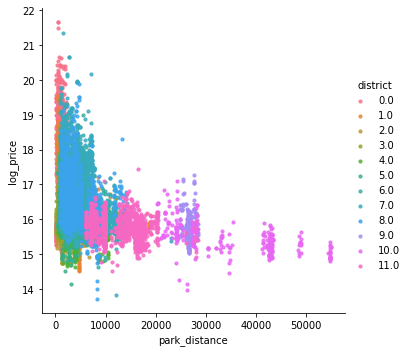

In [94]:
data["price"].corr(data['park_distance'])
data['log_price']= np.log(data['price'])
sns.lmplot('park_distance', 'log_price', data=data, hue= 'district', fit_reg=False, scatter_kws={"s": 10})

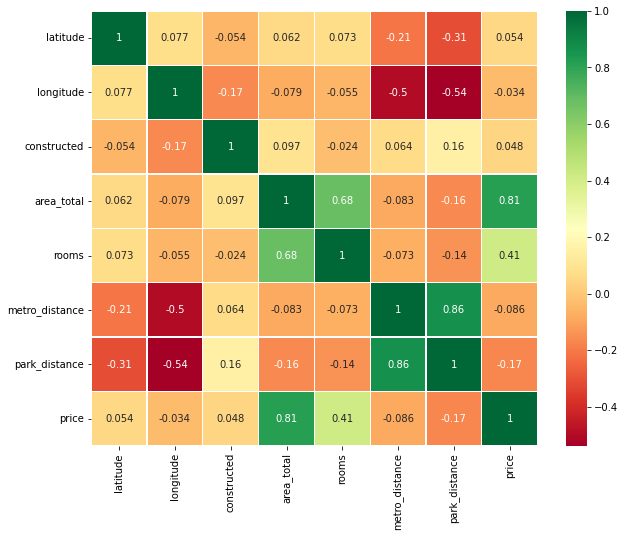

In [158]:
sns.heatmap(data[['latitude', 'longitude', 'constructed', 'area_total', 'rooms', 'metro_distance', 'district', 'park_distance', 'price']].corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [151]:
import sklearn.model_selection as model_selection

data_train, data_valid = model_selection.train_test_split(data, test_size=0.33, stratify=np.log(data.price).round())

In [168]:
features = ['latitude', 'longitude', 'constructed', 'area_total', 'rooms', 'metro_distance', 'district', 'park_distance', 'material', 'condition', 'heating']
X_train = data_train[features]
y_train = data_train.loc[X_train.index].price
X_valid = data_valid[features]
y_valid = data_valid.loc[X_valid.index].price


lgb_mod = lgb.LGBMRegressor(
    num_leaves=10,
    max_depth=5, 
    random_state=42, 
    silent=True, 
    metric='rmse',
    n_jobs=4, 
    n_estimators=2000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05,
    categorical_feature= 'name:district',
    seed = 42
)

lgb_mod.fit(X_train, np.log(y_train))

[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42


LGBMRegressor(boosting_type='gbdt', categorical_feature='name:district',
              class_weight=None, colsample_bytree=0.95, importance_type='split',
              learning_rate=0.05, max_depth=5, metric='rmse',
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=2000, n_jobs=4, num_leaves=10, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, seed=42,
              silent=True, subsample=0.9, subsample_for_bin=200000,
              subsample_freq=0)

In [166]:
preds_valid = lgb_mod.predict(X_valid)
print('Validation RMSLE: ', rmlse(y_valid, np.exp(preds_valid)))

Validation RMSLE:  0.14676366064791768


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

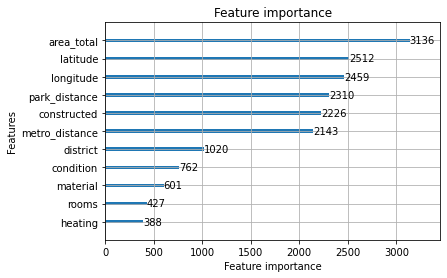

In [167]:
lgb.plot_importance(lgb_mod)

In [101]:
preds_test = lgb_mod.predict(data_test[features])
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = np.exp(preds_test)
submission.to_csv('submissions/metroandpark_submission.csv', index=False)

In [182]:
import optuna 
from sklearn.model_selection import KFold
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    params = {
        'verbose': -1,
        'metric': 'rmse', 
        'random_state': 42,
        'n_estimators': 3000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 3, 50)
    }
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    pruning_callback = LightGBMPruningCallback(trial, "rmse")

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = np.log(y[train_idx]), y[test_idx]

        lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
        lgb_eval = lgb.Dataset(X_test, y_test,free_raw_data=False)
        model = lgb.train(params, 
            lgb_train, valid_sets=lgb_eval, 
            verbose_eval=False, callbacks = [pruning_callback], early_stopping_rounds=100,
            categorical_feature= ['district'])
    
        preds = np.exp(model.predict(X_test))
        cv_scores[idx] = rmlse(y_test, preds)
    
    return np.mean(cv_scores)

In [183]:
import warnings
warnings.filterwarnings("ignore")
X = data[features]   
y = data['price']

study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

[I 2021-10-19 12:36:57,225] A new study created in memory with name: LGBM Regressor


['latitude', 'longitude', 'constructed', 'area_total', 'rooms', 'metro_distance', 'district', 'park_distance', 'material', 'condition', 'heating']


[I 2021-10-19 12:39:01,212] Trial 0 finished with value: 0.14981935929521722 and parameters: {'reg_alpha': 0.02046790853203148, 'reg_lambda': 1.5971379186502335, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 226, 'min_child_samples': 122, 'cat_smooth': 38}. Best is trial 0 with value: 0.14981935929521722.
[I 2021-10-19 12:40:17,504] Trial 1 finished with value: 0.15017798099298962 and parameters: {'reg_alpha': 0.022422611848675195, 'reg_lambda': 0.011118870562611393, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 379, 'min_child_samples': 149, 'cat_smooth': 36}. Best is trial 0 with value: 0.14981935929521722.
[I 2021-10-19 12:41:41,374] Trial 2 finished with value: 0.15829284576561026 and parameters: {'reg_alpha': 0.005742402338758533, 'reg_lambda': 1.6212870366328167, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 81, 'min_child_s

In [187]:
study.optimize(func, n_trials=10)

[I 2021-10-19 13:17:04,923] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2021-10-19 13:19:13,276] Trial 21 finished with value: 0.14146835710710867 and parameters: {'reg_alpha': 0.06480687765198427, 'reg_lambda': 9.737740372561735, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 967, 'min_child_samples': 43, 'cat_smooth': 50}. Best is trial 21 with value: 0.14146835710710867.
[I 2021-10-19 13:19:45,786] Trial 22 pruned. Trial was pruned at iteration 2587.
[I 2021-10-19 13:19:52,847] Trial 23 pruned. Trial was pruned at iteration 1058.
[I 2021-10-19 13:19:52,976] Trial 24 pruned. Trial was pruned at iteration 0.
[I 2021-10-19 13:19:53,125] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2021-10-19 13:19:53,400] Trial 26 pruned. Trial was pruned at iteration 9.
[I 2021-10-19 13:19:53,511] Trial 27 pruned. Trial was pruned at iteration 1.
[I 2021-10-19 13:21:05,634] Trial 28 finished with value: 0.145776541649995 and parameter

In [184]:
X_train = data[features]
y_train = data.loc[X_train.index].price

lgb_mod = lgb.LGBMRegressor(
    random_state = 42,
    metric='rmse',
    n_estimators= 3000,
    **study.best_params
)

lgb_mod.fit(X_train, np.log(y_train))

LGBMRegressor(boosting_type='gbdt', cat_smooth=49, class_weight=None,
              colsample_bytree=0.9, importance_type='split',
              learning_rate=0.017, max_depth=20, metric='rmse',
              min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=3000, n_jobs=-1, num_leaves=944, objective=None,
              random_state=42, reg_alpha=0.6549569729900814,
              reg_lambda=9.407319995031047, silent=True, subsample=0.5,
              subsample_for_bin=200000, subsample_freq=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

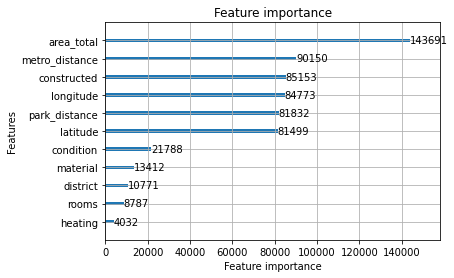

In [185]:
lgb.plot_importance(lgb_mod)

In [186]:
preds_test = lgb_mod.predict(data_test[features])
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = np.exp(preds_test)
submission.to_csv('submissions/lgbm_submission.csv', index=False)